Example usage of MulensModel to fit a point lens light curve to the
data file phot_ob08092_O4.dat. It uses Scipy Nelder-Mead minimization method.

In [1]:
import os
import scipy.optimize as op
import matplotlib.pyplot as plt

import MulensModel as mm

In [2]:
def chi2_fun(theta, parameters_to_fit, event):
    """
    Calculate chi2 for given values of parameters

    Keywords :
        theta: *np.ndarray*
            Vector of parameter values, e.g.,
            `np.array([5380., 0.5, 20.])`.

        parameters_to_fit: *list* of *str*
            List of names of parameters corresponding to theta, e.g.,
            `['t_0', 'u_0', 't_E']`.

        event: *MulensModel.Event*
            Event which has datasets for which chi2 will be calculated.

    Returns :
        chi2: *float*
            Chi2 value for given model parameters.
    """
    # First we have to change the values of parameters in
    # event.model.parameters to values given by theta.
    for (parameter, value) in zip(parameters_to_fit, theta):
        setattr(event.model.parameters, parameter, value)

    # After that, calculating chi2 is trivial:
    return event.get_chi2()

In [5]:
# Read in the data file
SAMPLE_FILE_01 = os.path.join(
    mm.DATA_PATH, "photometry_files", "OB08092",
    "phot_ob08092_O4.dat")
data = mm.MulensData(file_name=SAMPLE_FILE_01)

In [6]:
# PUTTING IN PRIORS

# Initialize the fit
parameters_to_fit = ["t_0", "u_0", "t_E"]
# Approximate values of the parameters are needed:
t_0 = 5380.
u_0 = 0.5
t_E = 25.
model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})

In [7]:
# Link the data and the model
event = mm.Event(datasets=data, model=model)
print('Initial Trial\n{0}'.format(event.model.parameters))

Initial Trial
    t_0 (HJD)       u_0    t_E (d) 
   5380.00000  0.500000    25.0000 



In [11]:
# RUNNING THE FIT

# Find the best-fit parameters
initial_guess = [t_0, u_0, t_E]
result = op.minimize(
    chi2_fun, x0=initial_guess, args=(parameters_to_fit, event),
    method='Nelder-Mead')
print(result.x)
(fit_t_0, fit_u_0, fit_t_E) = result.x

# Save the best-fit parameters
chi2 = chi2_fun(result.x, parameters_to_fit, event)

[5.37957091e+03 5.22979273e-01 1.79400200e+01]
Best Fit: t_0 =   5379.57091, u_0 = 0.5230, t_E =   17.940


In [10]:
# RESULTING POSTERIORS FROM FIT

#print best-fit params
msg = 'Best Fit: t_0 = {0:12.5f}, u_0 = {1:6.4f}, t_E = {2:8.3f}'
print(msg.format(fit_t_0, fit_u_0, fit_t_E))

# print chi2 fit results
print('Chi2 = {0:12.2f}'.format(chi2))
print('scipy.optimize.minimize result:')
print(result)

Best Fit: t_0 =   5379.57091, u_0 = 0.5230, t_E =   17.940
Chi2 =       427.20
scipy.optimize.minimize result:
 final_simplex: (array([[5.37957091e+03, 5.22979273e-01, 1.79400200e+01],
       [5.37957091e+03, 5.22981098e-01, 1.79399782e+01],
       [5.37957091e+03, 5.22974534e-01, 1.79401081e+01],
       [5.37957091e+03, 5.22975728e-01, 1.79400977e+01]]), array([427.20382193, 427.20382193, 427.20382194, 427.20382196]))
           fun: 427.20382192774014
       message: 'Optimization terminated successfully.'
          nfev: 196
           nit: 103
        status: 0
       success: True
             x: array([5.37957091e+03, 5.22979273e-01, 1.79400200e+01])


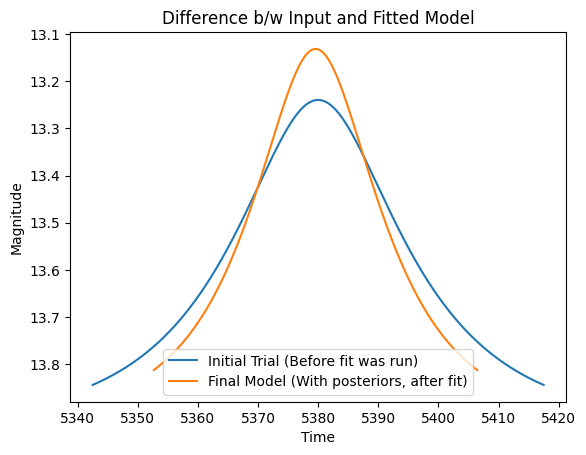

In [14]:
# Plot and compare the two models
init_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})
final_model = mm.Model({'t_0': fit_t_0, 'u_0': fit_u_0, 't_E': fit_t_E})

init_fit = mm.FitData(dataset=data, model=init_model)
init_fit.fit_fluxes()
final_fit = mm.FitData(dataset=data, model=final_model)
final_fit.fit_fluxes()

plt.figure()
init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Trial (Before fit was run)')
final_model.plot_lc(
    source_flux=final_fit.source_flux, blend_flux=final_fit.blend_flux,
    label='Final Model (With posteriors, after fit)')
plt.title('Difference b/w Input and Fitted Model')
plt.legend(loc='best')

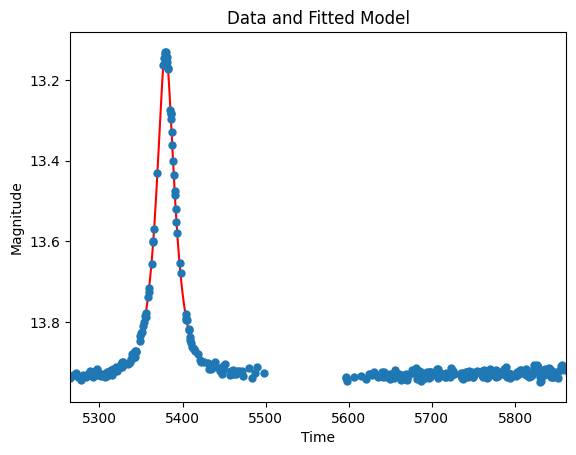

In [13]:
# FINAL FIT USING POSTERIORS FITS THE DATA VERY WELL

# Plot the fitted model with the data
plt.figure()
event.plot_data()
event.plot_model(color='red')
plt.title('Data and Fitted Model')

plt.show()